# CNN for Sentence Classification (Sentiment Analysis)
- It is widely known that CNNs are good for snapshot-like data, like images
- However, CNNs are effectve for NLP tasks as well
- For more information, refer to:
    - Kim 2014 (http://emnlp2014.org/papers/pdf/EMNLP2014181.pdf)
    - Zhang et al 2015 (https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)
    
<br>
- In this section, we perform sentence classification with CNNs (Kim 2014)
</br>
<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM.png" style="width: 800px"/>

<br>
- Pixels are made of embedding vectors of each word in a sentence
- Convolutions are performed based on word-level
- Classify each sentence as positive (1) or negative (0)

<img src="http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-12.05.40-PM.png" style="width: 600px"/>

## Dataset (+preprocessing)
- IMDb Movie reviews sentiment classification Dataset
- Doc: https://keras.io/datasets/
- Parameter description
    - num_features: number of words to account for (i.e., only frequent n words are considered)
    - sequence_length: maximum number of words for a sentence (if sentence is too short, pad by zeros)
    - embedding_dimension: dimensionality of embedding space (i.e., dimensionality of vector representation for each word)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
num_features = 3000
sequence_length = 300
embedding_dimension = 100

In [8]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_features)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(25000,)
(25000,)
(25000,)
(25000,)


In [9]:
X_train = pad_sequences(X_train, maxlen=sequence_length, padding='pre')
X_test = pad_sequences(X_test, maxlen=sequence_length, padding='pre')

print(X_train.shape)
print(X_test.shape)

(25000, 300)
(25000, 300)


In [10]:
X_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    1,   14,   22,   16,   43,  530,
        973, 1622, 1385,   65,  458,    2,   66,    2,    4,  173,   36,
        256,    5,   25,  100,   43,  838,  112,   50,  670,    2,    9,
         35,  480,  284,    5,  150,    4,  172,  112,  167,    2,  336,
        385,   39,    4,  172,    2, 1111,   17,  546,   38,   13,  447,
          4,  192,   50,   16,    6,  147, 2025,   19,   14,   22,    4,
       1920,    2,  469,    4,   22,   71,   87,   

## 1. Basic CNN sentence classification model
- Basic CNN using 1D convolution and pooling
- Known as "temporal convolution"

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, Embedding
from tensorflow.keras import optimizers

In [27]:
tf.keras.backend.clear_session()

In [28]:
def imdb_cnn_temporal():
    model = Sequential()
    
    # use Embedding layer to create vector representation of each word => it is fine-tuned every iteration
    model.add(Embedding(input_dim=num_features, output_dim=embedding_dimension, input_length=sequence_length))
    model.add(Conv1D(filters=50, kernel_size=5, strides=1, padding='valid'))
    model.add(MaxPooling1D(pool_size=2, padding='valid'))
    
    model.add(Flatten())
    
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    adam=optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [29]:
model = imdb_cnn_temporal()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          300000    
_________________________________________________________________
conv1d (Conv1D)              (None, 296, 50)           25050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 148, 50)           0         
_________________________________________________________________
flatten (Flatten)            (None, 7400)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                74010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 399,071
Trainable params: 399,071
Non-trainable params: 0
__________________________________________________

In [16]:
%%time
history = model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose = 0)

CPU times: user 1h 24min 53s, sys: 33min 24s, total: 1h 58min 18s
Wall time: 40min 41s


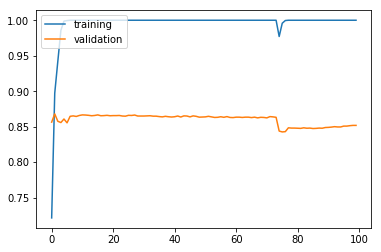

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [21]:
results = model.evaluate(X_test, y_test, verbose=0)

In [22]:
print('Test accuracy: ', results[1])

Test accuracy:  0.85576


## 2. Advanced CNN sentence classification model - 1
- Advanced CNN using 2D convolution and pooling
    - Embedding layer is "reshaped" to 4D to fit into 2D convolutional layer
- Perform global max pooling for each window

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, GlobalMaxPooling2D, Flatten, Embedding, Reshape, Dropout
from tensorflow.keras import optimizers

In [30]:
def imdb_cnn_adv():
    model = Sequential()
    
    model.add(Embedding(input_dim=num_features, output_dim=embedding_dimension, input_length=sequence_length))
    model.add(Reshape(target_shape=(sequence_length, embedding_dimension, 1)))
    
    model.add(Conv2D(filters=50, kernel_size=(5, embedding_dimension), strides=(1,1), padding='valid'))
    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate=0.3))
    
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate=0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    
    adam=optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
    
    return model    

In [31]:
model = imdb_cnn_adv()

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          300000    
_________________________________________________________________
reshape (Reshape)            (None, 300, 100, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 296, 1, 50)        25050     
_________________________________________________________________
global_max_pooling2d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [ ]:
%%time
history = model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose = 0)

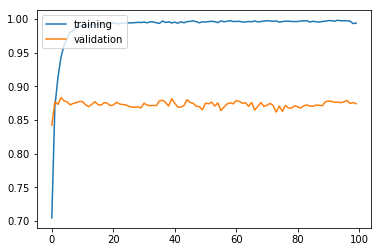

In [88]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [89]:
results = model.evaluate(X_test, y_test)

24192/25000 [============================>.] - ETA: 0s

In [90]:
print('Test accuracy: ', results[1])

Test accuracy:  0.86628


## 3. Advanced CNN sentence classification model - 2
- Structure more similar to that proposed in **Kim 2014**
    - Three convoltion operations with different filter sizes are performed and their results are merged

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, Embedding, Reshape, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras import optimizers

In [71]:
tf.keras.backend.clear_session()

In [72]:
def conv_model_kim():
    inn = Input(shape=(sequence_length, embedding_dimension, 1))
    
    # we conduct three convolutions & poolings then concatenate them.
    convolutions=[]
    filter_sizes=[3,4,5]
    for fs in filter_sizes:
        conv = Conv2D(filters=50, kernel_size=(fs, embedding_dimension), strides=(1,1), padding='valid', activation='relu')(inn)
        maxpool = MaxPooling2D(pool_size=(sequence_length-fs+1, 1), padding='valid')(conv)
#         maxpool = GlobalMaxPooling2D()(conv) ### This creates the output shape of (None, 50) rather than (None, 1, 1, 50)
        convolutions.append(maxpool)
        
    outt = concatenate(convolutions)
    model = Model(inputs=inn, outputs=outt)
    
    return model   

In [73]:
conv_model = conv_model_kim()

conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 298, 1, 50)   15050       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 297, 1, 50)   20050       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 296, 1, 50)   25050       input_1[0][0]                    
______________________________________________________________________________________________

In [75]:
def imdb_cnn_adv_kim ():
    model = Sequential()
    
    model.add(Embedding(input_dim=num_features, output_dim=embedding_dimension, input_length=sequence_length))
    model.add(Reshape(target_shape=(sequence_length, embedding_dimension, 1)))
    
    # call convolution method defined above
    model.add(conv_model_kim())
    
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(rate=0.3))
    
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(rate=0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    
    adam = optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [76]:
model = imdb_cnn_adv_kim()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          300000    
_________________________________________________________________
reshape (Reshape)            (None, 300, 100, 1)       0         
_________________________________________________________________
model_1 (Model)              (None, 1, 1, 150)         60150     
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                7550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [ ]:
%%time
history = model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose = 0)

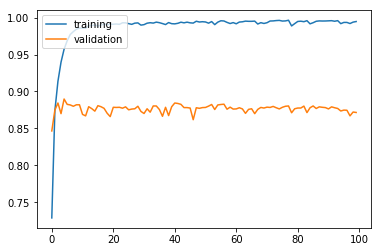

In [134]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [135]:
results = model.evaluate(X_test, y_test)

24768/25000 [============================>.] - ETA: 0s

In [136]:
print('Test accuracy: ', results[1])

Test accuracy:  0.87284


## 4. Advanced CNN sentence classification model - 3
- Structure more similar to that proposed in **Kim 2014**
    - More techniques are applied to generate more stable results

In [91]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, Embedding, Reshape, Conv2D, MaxPooling2D, concatenate
from tensorflow.keras import optimizers

In [92]:
tf.keras.backend.clear_session()

In [93]:
def conv_model_kim():
    inn = Input(shape=(sequence_length, embedding_dimension, 1))
    
    # we conduct three convolutions & poolings then concatenate them.
    convolutions=[]
    filter_sizes=[3,4,5]
    for fs in filter_sizes:
        conv = Conv2D(filters=50, kernel_size=(fs, embedding_dimension), strides=(1,1), padding='valid', activation='relu')(inn)
        maxpool = MaxPooling2D(pool_size=(sequence_length-fs+1, 1), padding='valid')(conv)
#         maxpool = GlobalMaxPooling2D()(conv) ### This creates the output shape of (None, 50) rather than (None, 1, 1, 50)
        convolutions.append(maxpool)
        
    outt = concatenate(convolutions)
    model = Model(inputs=inn, outputs=outt)
    
    return model   

In [94]:
conv_model = conv_model_kim()

conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 298, 1, 50)   15050       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 297, 1, 50)   20050       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 296, 1, 50)   25050       input_1[0][0]                    
______________________________________________________________________________________________

In [95]:
def imdb_cnn_adv_kim_2 ():
    model = Sequential()
    
    model.add(Embedding(input_dim=num_features, output_dim=embedding_dimension, input_length=sequence_length))
    model.add(Reshape(target_shape=(sequence_length, embedding_dimension, 1)))
    model.add(Dropout(rate=0.5))
    
    # call convolution method defined above
    model.add(conv_model_kim())
    
    model.add(Flatten())
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(10, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    adam = optimizers.Adam(lr=0.001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
    
    return model

In [96]:
model = imdb_cnn_adv_kim_2()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          300000    
_________________________________________________________________
reshape (Reshape)            (None, 300, 100, 1)       0         
_________________________________________________________________
dropout (Dropout)            (None, 300, 100, 1)       0         
_________________________________________________________________
model_1 (Model)              (None, 1, 1, 150)         60150     
_________________________________________________________________
flatten (Flatten)            (None, 150)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                7550      
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                2

In [ ]:
%%time
history = model.fit(X_train, y_train, batch_size = 50, epochs = 100, validation_split = 0.2, verbose = 0)

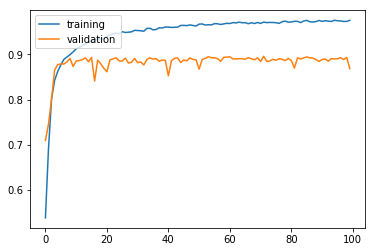

In [149]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

In [150]:
results = model.evaluate(X_test, y_test)

25000/25000 [==============================] - 3s     


In [151]:
print('Test accuracy: ', results[1])

Test accuracy:  0.86876
